In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Построим графики

In [2]:
import re

regex = re.compile(r'^[\d]+_x=([-\d.]+)_z=([-\d.]+)_a=([-\d.]+)_h=([-\d.]+)[.]csv$')

def label_from_path(path):
    label = path.split('\\')[-1] # PLATFORM DEPENDENT!
    m = regex.match(label)
    out = [float(x) for x in m.groups()]
    return torch.tensor(out, dtype=torch.float)

def data_from_path(path):
    data = pd.read_csv(path, sep=';')

    time = data.values[:,0]
    vx   = data.values[:,1::2]
    vz   = data.values[:,2::2]
    vabs = (vx ** 2 + vz ** 2) ** (1/2)
    
    vx   = torch.from_numpy(vx)
    vz   = torch.from_numpy(vz)
    vabs = torch.from_numpy(vabs)
    
    vx_fft   = torch.view_as_real(torch.fft.fft(vx)).permute(2, 0, 1)
    vz_fft   = torch.view_as_real(torch.fft.fft(vz)).permute(2, 0, 1)
    vabs_fft = torch.view_as_real(torch.fft.fft(vabs)).permute(2, 0, 1)

    ret = torch.cat([vx.unsqueeze(0), vz.unsqueeze(0), vabs.unsqueeze(0), vx_fft, vz_fft, vabs_fft], dim=0)

    return ret

class CSVDataset(Dataset):
    def __init__(self, path, device):
        self.device = device
        self.csv_list = [
            (path + "\\" + i) for i in os.listdir(path) if i.split('.')[-1] == 'csv'
        ]

    def __getitem__(self, item):
        d = data_from_path(self.csv_list[item]).to(device=device, dtype=torch.float)
        l = label_from_path(self.csv_list[item]).to(device=device, dtype=torch.float)
        return d, l

    def __len__(self):
        return len(self.csv_list)

# Модель 1

In [ ]:
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()

        self.feature_extractor = nn.Sequential(
            #        in  out  ker size
            nn.Conv2d(9, 256, 3),     # 9 = len([v_x, v_y, v_abs, 2*fft_vx, 2*fft_vy, 2*fft_vabs, ])
            nn.MaxPool2d(2, 2), 
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 512, 3, 2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 1024, 3, 2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),

            nn.Conv2d(1024, 512, 2),
        )

        self.linear = nn.Linear(45, 256)
        self.conv = nn.Sequential(
            nn.Conv2d(512, 1, 1),
            nn.ReLU(inplace=True)
            )

        self.linear2 = nn.Linear(256, 4) # 4 = x, z, a, h

    def forward(self, input):
        x = self.feature_extractor(input)
        x = x.permute(0, 1, 3, 2)
        x = self.linear(x)
        x = self.conv(x)
        x = x.squeeze(1).squeeze(1)
        x = self.linear2(x)

        return x

In [3]:
from tqdm import tqdm

predictor = Predictor().to(device)
loss_fn = nn.MSELoss()

weight_path = ".\\weights"
epoch_list = [ (weight_path + "\\" + i) for i in os.listdir(weight_path)]

out_list = []

print(epoch_list)

['.\\weights\\lastest_0_45718.42092561849', '.\\weights\\lastest_10_893.2206697387695', '.\\weights\\lastest_11_865.6638067830404', '.\\weights\\lastest_12_675.6369711812338', '.\\weights\\lastest_13_644.1288631184896', '.\\weights\\lastest_14_612.9963515421549', '.\\weights\\lastest_15_553.7910185750326', '.\\weights\\lastest_16_520.0451358846028', '.\\weights\\lastest_17_536.1971237080892', '.\\weights\\lastest_18_503.4557669474284', '.\\weights\\lastest_19_371.2722960611979', '.\\weights\\lastest_1_4380.993061767578', '.\\weights\\lastest_20_421.7247384033203', '.\\weights\\lastest_21_423.6021992085775', '.\\weights\\lastest_22_403.09191474405924', '.\\weights\\lastest_23_340.65574354044594', '.\\weights\\lastest_24_302.9916340230306', '.\\weights\\lastest_2_2399.6213155110677', '.\\weights\\lastest_3_2000.367135172526', '.\\weights\\lastest_4_1690.668668294271', '.\\weights\\lastest_5_1477.8920306396485', '.\\weights\\lastest_6_1225.4641667073568', '.\\weights\\lastest_7_1225.80642

In [6]:
for fname in epoch_list:
    predictor.load_state_dict(torch.load(fname))
    test_data_loader = DataLoader(CSVDataset(".\\csv_test", device), batch_size=8, shuffle=True)
    total_loss = 0
    for data, label in tqdm(test_data_loader):
        with torch.no_grad():
            outputs = predictor(data)
            total_loss += loss_fn(outputs, label)
    
    out_list.append( (fname, total_loss / len(test_data_loader)) )

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:47<00:00,  1.56it/s]


# Результаты модели 1

Train loss        Test loss
45718.42092561849 7149.2001953125
893.2206697387695 968.4253540039062
865.6638067830404 887.6771240234375
675.6369711812338 900.6986694335938
644.1288631184896 839.3199462890625
612.9963515421549 805.622802734375
553.7910185750326 649.2198486328125
520.0451358846028 537.1315307617188
536.1971237080892 571.3587036132812
503.4557669474284 685.5222778320312
371.2722960611979 442.04052734375
4380.993061767578 3077.397216796875
421.7247384033203 580.1550903320312
423.6021992085775 487.5481262207031
403.09191474405924 412.7155456542969
340.65574354044594 487.2925109863281
302.9916340230306 457.4757995605469
2399.6213155110677 2641.980224609375
2000.367135172526 1745.7052001953125
1690.668668294271 1623.0545654296875
1477.8920306396485 1075.8087158203125
1225.4641667073568 1401.0560302734375
1225.8064201049804 1059.9393310546875
983.1471684570313 1008.158447265625
806.7203869832357 1129.2156982421875
45718.42092561849 6681.580078125
893.2206697387695 772.6471557617

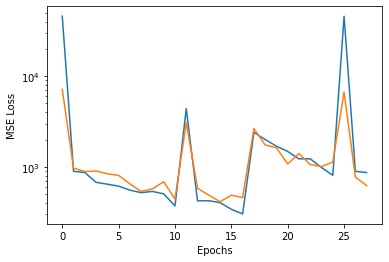

In [23]:
import matplotlib.pyplot as plt

a = []
b = []

print("Train loss        Test loss")
for x in out_list:
    a.append(float(x[0].split('_')[-1]))
    b.append(float(x[1]))
    print(a[-1], b[-1])
    
plt.yscale("log")

plt.xlabel('Epochs')
plt.ylabel('MSE Loss')

plt.plot(a)
plt.plot(b)
plt.show()

In [25]:
# BEST EPOCH IS 10
print("Train loss        Test loss")
print(a[10], b[10])

Train loss        Test loss
371.2722960611979 442.04052734375


# Модель 2

In [30]:
from tqdm import tqdm

predictor = Predictor().to(device)
loss_fn = nn.MSELoss()

weight_path = ".\\weights2"
epoch_list = [ (weight_path + "\\" + i) for i in os.listdir(weight_path)]

out_list = []

print(epoch_list)

['.\\weights2\\lastest_0_38402.61959065755', '.\\weights2\\lastest_10_860.2220416870117', '.\\weights2\\lastest_11_885.8546338907878', '.\\weights2\\lastest_12_631.0371058146159', '.\\weights2\\lastest_13_651.6892075195312', '.\\weights2\\lastest_14_698.8807584431967', '.\\weights2\\lastest_15_637.4185698038737', '.\\weights2\\lastest_16_507.3536002400716', '.\\weights2\\lastest_17_538.5775926208496', '.\\weights2\\lastest_18_463.34521823120116', '.\\weights2\\lastest_19_490.6890422973633', '.\\weights2\\lastest_1_3517.890502766927', '.\\weights2\\lastest_20_426.86609565226235', '.\\weights2\\lastest_21_434.7606809285482', '.\\weights2\\lastest_22_462.1349581604004', '.\\weights2\\lastest_23_394.8121796061198', '.\\weights2\\lastest_24_461.16275701904294', '.\\weights2\\lastest_2_2304.585198852539', '.\\weights2\\lastest_3_1973.3168083902995', '.\\weights2\\lastest_4_1533.303080037435', '.\\weights2\\lastest_5_1339.7622233072916', '.\\weights2\\lastest_6_1191.8854018961588', '.\\weight

In [31]:
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()

        self.feature_extractor = nn.Sequential(
            #        in  out  ker size
            nn.Conv2d(9, 128, 3),     # 9 = len([v_x, v_y, v_abs, 2*fft_vx, 2*fft_vy, 2*fft_vabs, ])
            nn.MaxPool2d(2, 2), 
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128), #CHANGED

            nn.Conv2d(128, 512, 3, 2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 1024, 3, 2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),

            nn.Conv2d(1024, 512, 2),
        )

        self.linear = nn.Linear(45, 256)
        self.conv = nn.Sequential(
            nn.Conv2d(512, 1, 1),
            nn.ReLU(inplace=True)
            )

        self.linear2 = nn.Linear(256, 4) # 4 = x, z, a, h

    def forward(self, input):
        x = self.feature_extractor(input)
        x = x.permute(0, 1, 3, 2)
        x = self.linear(x)
        x = self.conv(x)
        x = x.squeeze(1).squeeze(1)
        x = self.linear2(x)

        return x

In [32]:
for fname in epoch_list:
    predictor.load_state_dict(torch.load(fname))
    test_data_loader = DataLoader(CSVDataset(".\\csv_test", device), batch_size=8, shuffle=True)
    total_loss = 0
    for data, label in tqdm(test_data_loader):
        with torch.no_grad():
            outputs = predictor(data)
            total_loss += loss_fn(outputs, label)
    
    out_list.append( (fname, total_loss / len(test_data_loader)) )

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


# Результаты модели 2

Train loss        Test loss
38402.61959065755 5092.11328125
860.2220416870117 750.200927734375
885.8546338907878 973.9069213867188
631.0371058146159 1166.58447265625
651.6892075195312 739.5370483398438
698.8807584431967 617.6380615234375
637.4185698038737 609.187255859375
507.3536002400716 600.5900268554688
538.5775926208496 730.8438720703125
463.34521823120116 622.0708618164062
490.6890422973633 486.8482360839844
3517.890502766927 2467.994140625
426.86609565226235 440.7988586425781
434.7606809285482 418.4544372558594
462.1349581604004 654.3386840820312
394.8121796061198 438.6369934082031
461.16275701904294 776.3901977539062
2304.585198852539 2168.390869140625
1973.3168083902995 2108.31396484375
1533.303080037435 1264.6961669921875
1339.7622233072916 1400.027099609375
1191.8854018961588 1488.4619140625
1098.9046418863932 969.4558715820312
1022.8942905476888 1056.484130859375
887.3866968994141 761.1541748046875


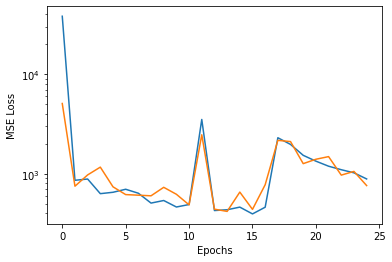

In [34]:
import matplotlib.pyplot as plt

a = []
b = []

print("Train loss        Test loss")
for x in out_list:
    a.append(float(x[0].split('_')[-1]))
    b.append(float(x[1]))
    print(a[-1], b[-1])
    
plt.yscale("log")

plt.xlabel('Epochs')
plt.ylabel('MSE Loss')

plt.plot(a)
plt.plot(b)
plt.show()

In [35]:
# BEST EPOCH IS 13
print("Train loss        Test loss")
print(a[13], b[13])

Train loss        Test loss
434.7606809285482 418.4544372558594
